In [107]:
import os
import tempfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.layers as layers
import imgaug as ia
import imgaug.augmenters as iaa

# %env LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/
%env LD_LIBRARY_PATH=$CONDA_PREFIX/lib/
%env LD_LIBRARY_PATH


SEED = 65932
ia.seed(SEED)

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

env: LD_LIBRARY_PATH=$CONDA_PREFIX/lib/
2.11.0
[]


In [108]:
batch_size = 16
img_height = 180
img_width = 180

HISTORY = None
MODEL = None


# data_augmentation = tf.keras.Sequential(
#     [
#         layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
#         layers.RandomRotation(0.1),
#         layers.RandomZoom(0.1),
#     ]
# )


MASTER_LIST = ["a1", "a1a", "a1b", "a2", "a2a", "a2b", "a3", "a4"]
# Model a1:  small dataset (https://data.mendeley.com/datasets/gjmr63rz2r/1)
# Model a1a: a1 with augmentations
# Model a1b: a1, cartoonized
# Model a2:  forest images dataset (https://data.mendeley.com/datasets/g5nzp6j3bt/3)
# Model a2a: a2 with augmentations
# Model a2b: a2, cartoonized





In [109]:
DATASET = 'a2a'
DO_TRAIN = False
DO_LOAD = True
DO_SAVE = True
DO_STATS = True

In [110]:
# validation set for all models
val_ds = tf.keras.utils.image_dataset_from_directory(
    # os.path.join(data_dir, 'val'),
    "validation" if DATASET[-1] != 'b' else "val-cartoon",
    # validation_split=0.2,
    # subset="validation",
    seed=SEED,
    image_size=(img_height, img_width),
    batch_size=batch_size)



SINGLE_FILES = []

fire_url = "https://s.yimg.com/uu/api/res/1.2/mP2yGlVbn9B9u8aP28IWHQ--~B/aD0xMTc1O3c9MTc2MztzbT0xO2FwcGlkPXl0YWNoeW9u/http://media.zenfs.com/en_us/News/ap_webfeeds/d4c52ccc91fdeb1a390f6a7067003bee.jpg"
fire_path = tf.keras.utils.get_file('fire', origin=fire_url)
img = tf.keras.utils.load_img(fire_path, target_size=(img_height, img_width))
img_array = tf.expand_dims(tf.keras.utils.img_to_array(img), 0) # Create a batch
SINGLE_FILES.append(img_array)

fire2_url = "https://th.bing.com/th/id/OIP.fBB1_8jfbLQVDE4jyh4AywHaFj?pid=ImgDet&rs=1"
fire2_path = tf.keras.utils.get_file('fire2', origin=fire2_url)
img = tf.keras.utils.load_img(fire2_path, target_size=(img_height, img_width))
img_array = tf.expand_dims(tf.keras.utils.img_to_array(img), 0) # Create a batch
SINGLE_FILES.append(img_array)

print(len(SINGLE_FILES))


Found 380 files belonging to 2 classes.
2


Found 10524 files belonging to 2 classes.
['fire', 'nofire']


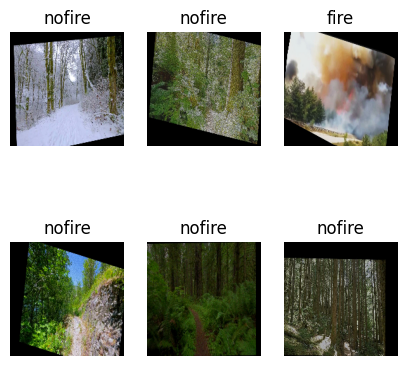

In [111]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    'dataset-' + DATASET,
    seed=SEED,
    image_size=(img_height, img_width),
    batch_size=batch_size)

class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

plt.figure(figsize=(5, 5))
for images, labels in train_ds.take(1):
    for i in range(6):
        # ax = plt.subplot(1, 7, i + 1)
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [112]:
MODEL = tf.keras.Sequential([
    # data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name="outputs")
])

MODEL.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

MODEL.build((None, img_height, img_width, 3))

MODEL.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 45, 45, 64)       

In [113]:
epochs = 15
if DO_TRAIN:
    # raise Exception("Not training...")
    HISTORY = MODEL.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs
    )
elif DO_LOAD:
    MODEL = tf.keras.models.load_model(os.path.join("models", DATASET))



In [114]:
if DO_STATS and DO_TRAIN:
    # raise Exception("Not doing stats...")

    acc = HISTORY.history['accuracy']
    val_acc = HISTORY.history['val_accuracy']

    loss = HISTORY.history['loss']
    val_loss = HISTORY.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [115]:
if DO_STATS:
    # raise Exception("Not doing stats...")
    
    print("Model " + DATASET + ":")

    MODEL.evaluate(
        val_ds
    )

    for image in SINGLE_FILES:
        predictions = MODEL.predict(image)
        score = tf.nn.softmax(predictions[0])

        print("This image most likely belongs to {} with a {:.6f} percent confidence.".format(
                class_names[np.argmax(score)], 100 * np.max(score)))



Model a2a:
1/1 [==============================] - 0s 59ms/step
This image most likely belongs to fire with a 99.975771 percent confidence.
1/1 [==============================] - 0s 24ms/step
This image most likely belongs to fire with a 99.961036 percent confidence.


In [116]:
if DO_SAVE and not DO_LOAD:
    MODEL.save(os.path.join("models", DATASET))

# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(MODEL)
tflite_model = converter.convert()

# Save the model.
with open(os.path.join("models", DATASET + '.tflite'), 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp21x3fke7/assets


INFO:tensorflow:Assets written to: /tmp/tmp21x3fke7/assets
2022-12-10 07:12:03.061765: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-12-10 07:12:03.061824: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-12-10 07:12:03.061971: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp21x3fke7
2022-12-10 07:12:03.062991: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-12-10 07:12:03.063005: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp21x3fke7
2022-12-10 07:12:03.065838: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-12-10 07:12:03.172740: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp21x3fke7
2022-12-10 07:12:03.179298: I tensorflow/cc/saved_model/loader.cc:305] SavedModel